## II - The Reactive Volatility Model (Paper 2) 

In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy as sp
import numpy as np 
import math
import datetime

# importer l'Excel de prix 

index_df = pd.read_excel('Data\indices.xls') 
index_df.head()

,Date,STOXX 600,STOXX 50,S&P 500,TOPIX,FTSE,DAX,NIKKEI,NASDAQ
0,1990-01-01,108.16,1098.49,353.40,2881.37,2422.7,1778.119995,38915.87109,454.82
1,1990-01-02,108.63,1101.34,359.69,2881.37,2434.1,1788.890015,38915.87109,459.33
2,1990-01-03,110.04,1112.82,358.76,2881.37,2463.7,1867.290039,38915.87109,460.90
3,1990-01-04,110.02,1113.02,355.67,2867.70,2451.6,1830.920044,38712.87891,459.39
4,1990-01-05,109.02,1099.52,352.20,2834.61,2444.5,1812.900024,38274.76172,458.22


### 2.1 - Realized Volatility 

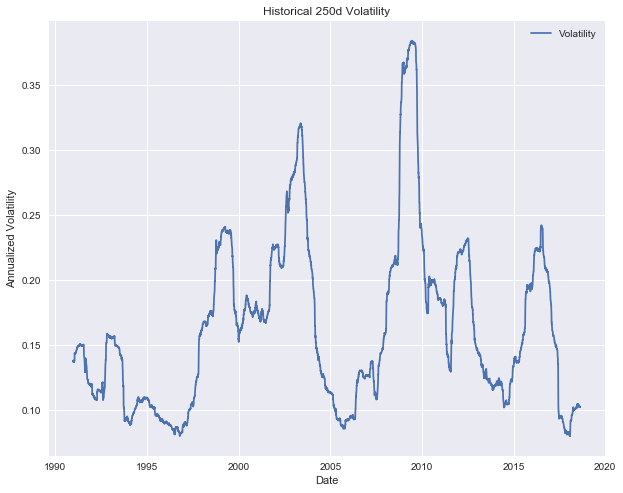

In [2]:
index_dictionnary = {"0" : "STOXX 600", "1":"STOXX 50","2" : "S&P 500","3" : "TOPIX", "4": "FTSE", "5":"DAX", "6":"NIKKEI","7":"NASDAQ"}

def computeRealizedVolatility(Ticker):
    
    n = len(index_df[Ticker])
    annualized_vol = []
    
    # Step 1 : compute the returns 
    gross_returns = (index_df[Ticker]/index_df[Ticker].shift(1)).dropna()
    
    # Step 2 : compute the 250-d vol
    for i in range(250,n):
        annualized_vol.append(np.sqrt(np.cov(gross_returns[i-250:i],gross_returns[i-250:i])[0][1]) * np.sqrt(250)) # on commence a calculer a partir row 250
    return annualized_vol

dates = index_df["Date"][250:len(index_df["Date"])]
dates = [pd.to_datetime(d) for d in dates]  # Conversion des dates dans le bon format
                         
volatility = {"Date" : dates, "Volatility" : computeRealizedVolatility("STOXX 600")} # Création d'un dictionnaire pour la vol
volatility_df =pd.DataFrame(volatility)

plt.style.use('seaborn')
volatility_df.plot(x= "Date", y='Volatility', figsize=(10, 8), grid=True)
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.title('Historical 250d Volatility')
plt.show()
    


### 2.2 - Reactive Volatility 

In [3]:
# Calcul des niveaux du stock index tels que calibrés par Bouchaud & al.

def compute_L_S(Ticker):
    
    lambda_S = 0.0241 # voir comment récupérer cette valeur depuis notre propre calibration
    n = len(index_df[Ticker])
    L_S = np.zeros(n)
    for i in range(1,n):
        L_S[i] = (1-lambda_S)*L_S[i-1] + lambda_S * index_df[Ticker][i]
    return L_S

def compute_L_F(Ticker):
    lambda_F = 0.1484 # voir comment récupérer cette valeur depuis notre propre calibration
    n = len(index_df[Ticker])
    L_F = np.zeros(n)
    for i in range(1,n):
        L_F[i] = (1-lambda_F)*L_F[i-1] + lambda_F * index_df[Ticker][i]
    return L_F

def phi(z):
    phi_parameter = 1/0.3
    return ((z*phi_parameter)/phi_parameter)

def compute_L_S_Hat(Ticker):
    
    n = len(index_df[Ticker])
    L_S = compute_L_S(Ticker)
    L_F = compute_L_F(Ticker)
    L_S_Hat = np.zeros(n)
    
    for i in range(1,n):
        L_S_Hat[i] = index_df[Ticker][i] * (1 + phi((L_S[i] - index_df[Ticker][i])/index_df[Ticker][i]))
    return L_S_Hat    

def compute_L(Ticker):
    
    n = len(index_df[Ticker])
    L_S = compute_L_S(Ticker)
    L_F = compute_L_F(Ticker)
    L_S_Hat = compute_L_S_Hat(Ticker)
    
    L = np.zeros(n)
    l = 8 ## Ce parametre provient du papier
    
    for i in range(1,n):
        L[i] = L_S_Hat[i]*(1+l*(L_F[i] - index_df[Ticker][i])/L_F[i])
    return L

def renormalized_variance(Ticker):
    n = len(index_df[Ticker])
    lambda_sigma = 0.025 ## Ce parametre provient du papier 
    L = compute_L(Ticker)
    
    sigma_tild = np.zeros(n)
    
    for i in range(1,n):
        sigma_tild[i] = (1-lambda_sigma)*sigma_tild[i-1] + lambda_sigma*(((index_df[Ticker][i]-index_df[Ticker][i-1])/L[i])**2)
    return sigma_tild

def reactive_volatility(Ticker):
    
    n = len(index_df[Ticker])
    L_S = compute_L_S(Ticker)
    L_F = compute_L_F(Ticker)
    sigma_tild = renormalized_variance(Ticker)
    sigma_reactive = np.zeros(n)
    l = 8
    
    for i in range(1,n):
        sigma_reactive[i] = sigma_tild[i] *(L_S[i]/index_df[Ticker][i])*(1+l*(L_F[i]-index_df[Ticker][i])/L_F[i])
    return sigma_reactive


C:\Users\romai\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


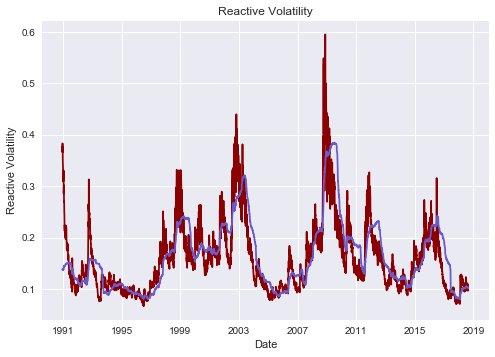

In [88]:
dates = index_df["Date"][250:len(index_df["Date"])]
dates = [pd.to_datetime(d) for d in dates]  # Conversion des dates dans le bon format

reactive_vol = np.sqrt(reactive_volatility("STOXX 600")) * np.sqrt(250)  # Sans oublier d'annualiser + passer a la racine

reactive_vol = reactive_vol[250:len(index_df["Date"])]

react_volatility_dict = {"Date" : dates, "Reactive Volatility" : reactive_vol} # Création d'un dictionnaire pour la vol
react_volatility_df =pd.DataFrame(react_volatility_dict)

plt.style.use('seaborn')


#react_volatility_df.plot(x= "Date", y="Reactive Volatility", figsize=(10, 8), grid=True, color = "darkred")
#react_volatility_df.plot(x= "Date", y='Historical Volatility', figsize=(10, 8), grid=True, color = "slateblue")

x = dates
y = reactive_vol
y2 = computeRealizedVolatility("STOXX 600")

plt.plot(x, y, color= "darkred")

plt.plot(x, y2, color = "slateblue")

plt.xlabel('Date')
plt.ylabel('Reactive Volatility')
plt.title('Reactive Volatility')

plt.show()

### Compute the Reactive Covariance Matrix 

Il suffit de reprendre les définitions plus haut et mettre deux tickers pour obtenir une matrice de var - covar 